# Demonstrate building a FC network with arbitrary graph structure

> This is the foundation for building a network based on gene pathways or similar.

In [ ]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
# pio.renderers.default = "svg"

from EnvDL.core import * # includes remove_matching_files
from EnvDL.dna import *
from EnvDL.dlfn import *

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from graphviz import Digraph
import torchviz

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
cache_path = '../nbs_artifacts/01.25_g2fc_demo_FC_graph/'
ensure_dir_path_exists(dir_path = cache_path)

## Define example graph

In [ ]:
vis_dot_bool = True

In [ ]:
kegg_connections = {
    'c1':['b1'],
    'c2':['b2'],
    'b1':['a1_input', 'b2'],
    'b2':['a2_input']}

In [ ]:
# add yhat node to the graph
temp_values = []
for key in kegg_connections.keys():
    temp_values += kegg_connections[key]

kegg_connections['y_hat'] = [key for key in kegg_connections.keys() if key not in temp_values]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 67869.00it/s]


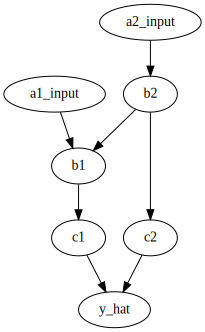

In [ ]:
# This is too big to render in full
dot = ''
if vis_dot_bool:
    dot = Digraph()
    for key in tqdm(kegg_connections.keys()):
        dot.node(key)
        for value in kegg_connections[key]:
            # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
            dot.edge(value, key)    

dot

Version with the node names masked for size 

## Setup to build the graph

In [ ]:
# start by finding the top level -- all those keys which are theselves not values
# helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
def find_uniq_keys_values(input_dict):
    all_keys = list(input_dict.keys())
    all_values = []
    for e in all_keys:
        all_values.extend(input_dict[e])
    all_values = list(set(all_values))

    return({'all_keys': all_keys,
           'all_values': all_values})

In [ ]:
# find the dependancies for run order from many dependancies to none
# wrapper function to find the nodes that aren't any other nodes dependancies.
def find_top_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])
# wrapper function to find the input nodes. They don't occur in the keys and thus won't be added to the list otherwise.
# another way to do this would have been to 
def find_input_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_values'] if e not in all_key_value_dict['all_keys']])

In [ ]:
# start by finding the top level -- all those keys which are theselves not values
res = find_uniq_keys_values(input_dict = kegg_connections)
all_keys = res['all_keys']
all_values = res['all_values']

# use the keys to find the input/outputs of the graph
output_nodes = [e for e in all_keys if e not in all_values]
input_nodes = [e for e in all_values if e not in all_keys]

# (output_nodes, input_nodes)

In [ ]:
# find the dependancies for run order from many dependancies to none
temp = kegg_connections.copy()

no_dependants = find_input_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
# first pass. Same as the output nodes identified above
dependancy_order = []
# Then iterate
for ith in range(100): #TODO <- this should be set as a input parameter
    top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
    if top_nodes == []:
        break
    else:
        dependancy_order += top_nodes    
        # remove nodes from the graph that are at the 'top' level and haven't already been removed
        for key in [e for e in dependancy_order if e in temp.keys()]:
             temp.pop(key)

# dependancy_order

In [ ]:
# reverse to get the order that the nodes should be called
dependancy_order.reverse()
# dependancy_order

In [ ]:
# Trying out new approach: add a node for the input data tha will only flatten the input.
dependancy_order = input_nodes+dependancy_order

for key in input_nodes:
    kegg_connections[key] = [] #[key] # needs to contain itself so the model's `get_input_node()` function works 
                               # or that function needs to change.
    

## Set up dict of input tensors

In [ ]:
n_obs = 100
# y_true = torch.from_numpy(np.concatenate([
#         np.ones((n_obs, )),
#         np.zeros((n_obs, ))], 0))
y_true = torch.from_numpy(np.concatenate([
        np.zeros((n_obs, )),
        np.ones( (n_obs, ))], 0))

In [ ]:
# try adding a little noise
y_true = y_true + .1* torch.rand(y_true.shape[0],)
y_true

tensor([0.0224, 0.0068, 0.0879, 0.0688, 0.0683, 0.0032, 0.0718, 0.0605, 0.0178,
        0.0824, 0.0527, 0.0211, 0.0346, 0.0208, 0.0719, 0.0829, 0.0430, 0.0484,
        0.0335, 0.0327, 0.0534, 0.0293, 0.0138, 0.0461, 0.0916, 0.0655, 0.0885,
        0.0599, 0.0798, 0.0971, 0.0394, 0.0280, 0.0139, 0.0182, 0.0872, 0.0986,
        0.0908, 0.0501, 0.0325, 0.0312, 0.0630, 0.0776, 0.0279, 0.0972, 0.0098,
        0.0222, 0.0133, 0.0152, 0.0986, 0.0861, 0.0665, 0.0920, 0.0613, 0.0787,
        0.0757, 0.0263, 0.0483, 0.0283, 0.0649, 0.0468, 0.0506, 0.0305, 0.0766,
        0.0349, 0.0320, 0.0784, 0.0306, 0.0285, 0.0535, 0.0073, 0.0241, 0.0090,
        0.0174, 0.0669, 0.0659, 0.0236, 0.0923, 0.0017, 0.0306, 0.0584, 0.0455,
        0.0710, 0.0175, 0.0324, 0.0776, 0.0056, 0.0924, 0.0573, 0.0140, 0.0979,
        0.0282, 0.0656, 0.0077, 0.0420, 0.0266, 0.0078, 0.0074, 0.0108, 0.0902,
        0.0545, 1.0631, 1.0910, 1.0234, 1.0849, 1.0694, 1.0762, 1.0805, 1.0788,
        1.0855, 1.0223, 1.0093, 1.0793, 

In [ ]:
input_tensor_dict = {
    'a1_input': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 3)),
        np.ones( (n_obs, 4, 3))], 0)),
    'a2_input': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 2)),  
        np.ones( (n_obs, 4, 2))], 0))}

# input_tensor_dict = {
#     'a1_input': torch.from_numpy(np.concatenate([
#         np.zeros((n_obs, 1, 1)),
#         np.ones( (n_obs, 1, 1))], 0)),
#     'a2_input': torch.from_numpy(np.concatenate([
#         np.zeros((n_obs, 1, 1)),  
#         np.ones( (n_obs, 1, 1))], 0))}

x_list_temp = [input_tensor_dict[key].to(torch.float) for key in input_tensor_dict.keys()]

## Figure out expected input/output shapes

_==NOTE! This assumes only dense connections!==_

In [ ]:
# This could be replaced by a sort of "distance from output" measure
default_output_size = 20 # <------------------------------------------------------------------------
output_size_dict = dict(zip(dependancy_order, 
                        [default_output_size for i in range(len(dependancy_order))]))
output_size_dict['y_hat'] = 1 
# output_size_dict

In [ ]:
# input nodes will only flatten the output so they have length channels*length.
for key in input_nodes:
    output_size_dict[key] = np.prod(np.array(input_tensor_dict[key].shape[1:]))

In [ ]:
output_size_dict

{'a1_input': 12,
 'a2_input': 8,
 'b2': 20,
 'b1': 20,
 'c2': 20,
 'c1': 20,
 'y_hat': 1}

In [ ]:
input_size_dict = kegg_connections.copy()

# use the expected output sizes from `output_size_dict` to fill in the non-data sizes
tensor_ndim = len(input_tensor_dict[list(input_tensor_dict.keys())[0]].shape)
for e in tqdm(input_size_dict.keys()):
    # overwrite named connections with the output size of those connections
    # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict

    # is there no channel dim? (major/minor allele)
    if 2 == tensor_ndim:
        input_size_dict[e] = [
            list(input_tensor_dict[ee].shape)[-1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)
            if ee in no_dependants
            else output_size_dict[ee] for ee in input_size_dict[e]]
    elif 3 == tensor_ndim: # There is a channel dim
        input_size_dict[e] = [
            (list(input_tensor_dict[ee].shape)[1]*list(input_tensor_dict[ee].shape)[2]) # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)  
            if ee in no_dependants
            else output_size_dict[ee] for ee in input_size_dict[e]]

# Now walk over entries and overwrite with the sum of the inputs
for e in tqdm(input_size_dict.keys()):
    input_size_dict[e] = np.sum(input_size_dict[e])

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 41410.62it/s]


In [ ]:
dot = ''
if vis_dot_bool:
    dot = Digraph()
    for key in tqdm(kegg_connections.keys()):
        key_label = str(key)+'\nin: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
        dot.node(key, key_label)
        for value in kegg_connections[key]:
            # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
            dot.edge(value, key)    

# dot

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26960.63it/s]


### Set up DataSet

Now we have

- A dictionary with the connections: `example_dict`
- The expected input sizes for each node: `example_dict_input_size`
- A dictionary with the input tensors: `input_tensor_dict`
- A list of the input tensors' names: `no_dependants` 
- A list with the order that each module should be called: `dependancy_order`

In [ ]:
class ListDataset(Dataset): 
    def __init__(self, 
                 y, 
                 x_list,
                 transform = None, target_transform = None,
                 **kwargs 
                ):
        self.device = device
        self.y = y 
        self.x_list = x_list
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
        
        x_idx =[x[idx, ] for x in self.x_list] 

        
        if self.target_transform:
            y_idx = self.transform(y_idx)
            x_idx = [self.transform(x) for x in x_idx]
            
        return y_idx, x_idx
    

To have a fair test of whether the model is working, I want to ensure there is information to learn in the dataset. To this end I'm using just two genotypes.

In [ ]:
training_dataloader = DataLoader(ListDataset(
        y = y_true[:, None].to(torch.float32),
        x_list = [e.to(torch.float32) for e in x_list_temp]
    ),
    batch_size = 20,
    shuffle = True)

### Set up NeuralNetwork

In [ ]:
# Working version ====
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 input_tensor_names,
                 dependancy_order
                ):
        super(NeuralNetwork, self).__init__()
        def Linear_block(in_size, out_size, drop_pr):
            block = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr))
            return(block)   
        
        
        # fill in the list in dependancy order. 
        layer_list = []
        for key in dependancy_order:
            if key in input_tensor_names:
                layer_list += [
                    nn.Flatten()
                ]
            elif key != 'y_hat':
                layer_list += [
                    Linear_block(in_size=example_dict_input_size[key], 
                                 out_size=example_dict_output_size[key], 
                                 drop_pr=0)
                              ]
            else:
                layer_list += [
                    nn.Linear(example_dict_input_size[key], 
                              example_dict_output_size[key])
                              ]
                

        self.nn_layer_list = nn.ModuleList(layer_list)

                    
        
        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        self.result_list = []
        self.result_list_lookup = {}
            

    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):  
#             print(input_node, self.result_list_lookup)
            return(self.result_list[self.result_list_lookup[input_node]])
        
        # trying reinstantiating to get around inplace replacement issue.
        self.result_list = []
        self.result_list_lookup = {}
        for key in self.dependancy_order:
#             print(key)

            input_nodes = self.example_dict[key]
            nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]
            
#             if key == 'y_hat':
#                 return(self.nn_layer_list[nn_layer_list_idx](torch.concat(
#                             [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
#                             -1)))
            
#             else:
#             if key not in self.result_list_lookup.keys():
            # I realllllly hope these are being copied by reference...
            # must be first before growing result_list
            self.result_list_lookup[key] = len(self.result_list_lookup)                
            if key in self.input_tensor_names: # If the input node is an input (flatten) layer
#                 print('ifif')
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
                    x[self.input_tensor_lookup[key]]
                ).clone()]

            else:
#                 print('ifel')
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)).clone()]

#             else:
#                 if key in self.input_tensor_names: # If the input node is an input (flatten) layer
#                     print('elif')
#                     self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
#                         x[self.input_tensor_lookup[key]]
#                     ).clone()]
#                 else:
#                     print('elel')
#                     self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
#                         [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
#                         -1)).clone()] 

#                 print((len(self.result_list), self.result_list))
        return self.result_list[self.result_list_lookup['y_hat']]
    

model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 

# model(next(iter(training_dataloader))[1])

In [ ]:
# # alternate version designed to use eval/exec instead of a nn.ModuleList

# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  example_dict, # contains the node (excluding input tensors)
#                  example_dict_input_size, # contains the input sizes (including the tensors)
#                  example_dict_output_size,
#                  input_tensor_names,
#                  dependancy_order
#                 ):
#         super(NeuralNetwork, self).__init__()
#         def Linear_block(in_size, out_size, drop_pr):
#             block = nn.Sequential(
#                 nn.Linear(in_size, out_size),
#                 nn.ReLU(),
#                 nn.Dropout(drop_pr))
#             return(block)   
        
#         # fill in the list in dependancy order. 
#         ## use setattr to initialize a net for each node on the graph ==============================
#         for key in dependancy_order:
#             if key in input_tensor_names:
#                 setattr(self, key, 
#                         nn.Flatten()) # input nodes are just flatten
#             elif key  != 'yhat':
#                 setattr(self, key, 
#                         Linear_block(
#                             in_size=example_dict_input_size[key], 
#                             out_size=example_dict_output_size[key], 
#                             drop_pr=0))
#             else:
#                 setattr(self, key,
#                     nn.Linear(example_dict_input_size[key], 
#                               example_dict_output_size[key])
#                        )
                
#         ## finished initializing ===================================================================


#         # things for get_input_node in forward to work.
#         self.example_dict = example_dict
#         self.input_tensor_names = input_tensor_names
#         self.dependancy_order = dependancy_order
        
#         self.input_tensor_lookup = dict(zip(input_tensor_names, 
#                                             [i for i in range(len(input_tensor_names))]))

#     def forward(self, x):
#         # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
# #         # I use a dict instead of a list comprehension here because there could be an arbitrarily
# #         # large number of inputs in the list. 
# #         def get_input_node(self, input_node, get_x):  
# #             return(self.result_list[self.result_list_lookup[input_node]])
        
# #         # trying reinstantiating to get around inplace replacement issue.
# #         self.result_list = []
# #         self.result_list_lookup = {}
# #         for key in self.dependancy_order:
# #             input_nodes = self.example_dict[key]
# #             nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]
            
# #             self.result_list_lookup[key] = len(self.result_list_lookup)                
# #             if key in self.input_tensor_names: # If the input node is an input (flatten) layer
# #                 self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
# #                     x[self.input_tensor_lookup[key]]
# #                 ).clone()]

# #             else:
# #                 self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
# #                     [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
# #                     -1)).clone()]
                
# #         return self.result_list[self.result_list_lookup['y_hat']]
#         for key in self.dependancy_order:    
#             if key in self.input_tensor_lookup.keys():
#                 print(key+' = '+'x['+str(self.input_tensor_lookup[key])+']')
#             else:
#                 inputs = self.example_dict[key]
#                 if len(inputs) == 1:
#                     print(key+' = self.'+key+'('+''.join(self.example_dict[key])+')')
#                 else:
#                     print(key+' = self.'+key+'(torch.concat(['+', '.join(self.example_dict[key])+'], -1))')


# model = NeuralNetwork(example_dict = kegg_connections, 
#                       example_dict_input_size = input_size_dict,
#                       example_dict_output_size = output_size_dict,
#                       input_tensor_names = list(input_tensor_dict.keys()),
#                       dependancy_order = dependancy_order) 

# # model(next(iter(training_dataloader))[1])

In [ ]:
model(next(iter(training_dataloader))[1])

a1_input = x[0]
a2_input = x[1]
b2 = self.b2(a2_input)
b1 = self.b1(torch.concat([a1_input, b2], -1))
c2 = self.c2(b2)
c1 = self.c1(b1)
y_hat = self.y_hat(torch.concat([c1, c2], -1))


In [ ]:
x = next(iter(training_dataloader))[1]
[e.shape for e in x]

[torch.Size([20, 4, 3]), torch.Size([20, 4, 2])]

In [ ]:
for key in dependancy_order:
    if key in input_tensor_lookup.keys():
        print(key+' = '+'x['+str(input_tensor_lookup[key])+']')
    else:
        inputs = input_dict[key]
        if len(inputs) == 1:
            print(key+' = self.'+key+'('+''.join(input_dict[key])+')')
        else:
            print(key+' = self.'+key+'(torch.concat('+', '.join(input_dict[key])+', -1))')
            
            


['a1_input', 'a2_input', 'b2', 'b1', 'c2', 'c1', 'y_hat']

In [ ]:
a2_input

NameError: name 'a2_input' is not defined

In [ ]:
exec('a2_input = "test"')

In [ ]:
eval(key)

'test'

In [ ]:
key = 'a2_input'


getattr(model, key)(x[model.input_tensor_lookup[key]])

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
key = 'b2'
getattr(model, key)

Sequential(
  (0): Linear(in_features=8, out_features=20, bias=True)
  (1): ReLU()
  (2): Dropout(p=0, inplace=False)
)

In [ ]:
# calling eval on 
#         setattr(self, "nn_layer_list", nn.ModuleList(layer_list))

In [ ]:
model.example_dict

{'c1': ['b1'],
 'c2': ['b2'],
 'b1': ['a1_input', 'b2'],
 'b2': ['a2_input'],
 'y_hat': ['c1', 'c2'],
 'a1_input': [],
 'a2_input': []}

a1_input = x[0]
a2_input = x[1]
b2 = self.b2(a2_input)
b1 = self.b1(torch.concat(a1_input, b2, -1))
c2 = self.c2(b2)
c1 = self.c1(b1)
y_hat = self.y_hat(torch.concat(c1, c2, -1))


In [ ]:
# model.input_tensor_names
model.dependancy_order
# model.input_tensor_lookup

['a1_input', 'a2_input', 'b2', 'b1', 'c2', 'c1', 'y_hat']

In [ ]:
# because the dictionary is not circular I can use dependancy order to replace each value with that value's value
# reverse_dependancy_order = model.dependancy_order.copy()
# reverse_dependancy_order.reverse()

dependancy_order = model.dependancy_order.copy()
input_tensor_names = model.input_tensor_names
input_tensor_lookup = model.input_tensor_lookup

input_dict = model.example_dict.copy()
dependancy_order

['a1_input', 'a2_input', 'b2', 'b1', 'c2', 'c1', 'y_hat']

In [ ]:
# input_dict

key = 'a1_input'

for key in dependancy_order:
    if key in input_tensor_lookup.keys():
        input_dict[key] = 'x['+str(input_tensor_lookup[key])+']'

In [ ]:
key = 'b2'

key+'('+''.join([input_dict[e] for e in input_dict[key]])+')'

'b2(x[1])'

In [ ]:
key = 'b1'

in_list = [input_dict[e] for e in input_dict[key]]

in_list_is_str = [True if type(e) == str else False for e in in_list]

if False not in in_list_is_str: # list fully expanded and ready for joining
    print(in_list)
else:
    pass

in_list_fail_idx = [i for i in range(len(in_list_is_str)) if False == in_list_is_str[i]]

i = in_list_fail_idx[0]


[input_dict[e] for e in in_list[i]]

# key+'('+
# ''.join(
# [input_dict[e] for e in input_dict[key]]
#)
# +')'

['x[1]']

In [ ]:
input_dict

{'c1': ['b1'],
 'c2': ['b2'],
 'b1': ['a1_input', 'b2'],
 'b2': ['a2_input'],
 'y_hat': ['c1', 'c2'],
 'a1_input': 'x[0]',
 'a2_input': 'x[1]'}

In [ ]:
# expand from y_hat?


TypeError: 'int' object is not iterable

In [ ]:
to_get = []

to_get = model.example_dict['y_hat']

In [ ]:
[ model.example_dict[e] for e in to_get]

[['b1'], ['b2']]

In [ ]:
sub_dict = model.example_dict # dictionary of substitutions
sub_dict

{'c1': ['b1'],
 'c2': ['b2'],
 'b1': ['a1_input', 'b2'],
 'b2': ['a2_input'],
 'y_hat': ['c1', 'c2'],
 'a1_input': [],
 'a2_input': []}

In [ ]:


def sub_item_fn(sub_dict, 
               list_item):
    if sub_dict[list_item] == []:
        return([list_item], True)
    else:
        return(sub_dict[list_item], False)
    
    

sub_item_fn(sub_dict = model.example_dict, list_item = 'b1')
sub_item_fn(sub_dict = model.example_dict, list_item = 'a1_input')


def sub_item_iter(sub_dict, list_item):
    vals = sub_item_fn(sub_dict = sub_dict, list_item = list_item)
    if vals[-1] == True:
        return(vals[0])
    else:
        return([sub_item_iter(sub_dict = sub_dict, list_item = e) for e in vals[0]])

sub_item_iter(sub_dict = model.example_dict, list_item = 'a1_input')    
sub_item_iter(sub_dict = model.example_dict, list_item = 'b1')    
sub_item_iter(sub_dict = model.example_dict, list_item = 'y_hat')   

[[[['a1_input'], [['a2_input']]]], [[['a2_input']]]]

In [ ]:
kegg_connections

{'c1': ['b1'],
 'c2': ['b2'],
 'b1': ['a1_input', 'b2'],
 'b2': ['a2_input'],
 'y_hat': ['c1', 'c2'],
 'a1_input': [],
 'a2_input': []}

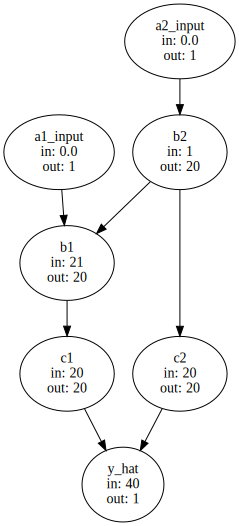

In [ ]:
dot

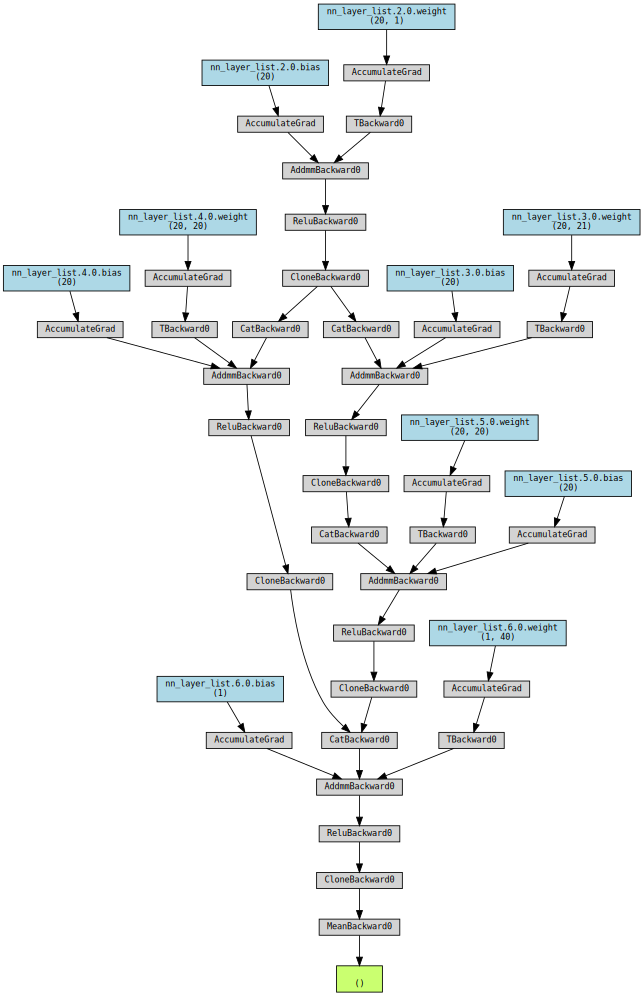

In [ ]:
yhat = model(next(iter(training_dataloader))[1])
torchviz.make_dot(yhat.mean(), params=dict(model.named_parameters())#, show_attrs=True, show_saved=True
                 )

### Train loop functions

In [ ]:
# the only 
def train_loop_yx(dataloader, model, loss_fn, optimizer, silent = False):
#     import numpy as np
#     import pandas as pd
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    size = len(dataloader.dataset)
    for batch, (y_i, xs_i) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(xs_i)
        loss = loss_fn(pred, y_i)

        # Backpropagation
        torch.autograd.set_detect_anomaly(True)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(y_i)
            if not silent:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def train_error_yx(dataloader, model, loss_fn, silent = False):
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)
            train_loss += loss_fn(pred, y_i).item() # <----------------------
            
    train_loss /= num_batches
    return(train_loss)

In [ ]:
def test_loop_yx(dataloader, model, loss_fn, silent = False):
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)                
            test_loss += loss_fn(pred, y_i).item() # <-----------------------

    test_loss /= num_batches
    if not silent:
        print(f"Test Error: Avg loss: {test_loss:>8f}")
    return(test_loss)

In [ ]:
def train_nn_yx(
    cache_path,
    training_dataloader,
    testing_dataloader,
    model,
    learning_rate = 1e-3,
    batch_size = 64,
    epochs = 500,
    model_prefix = 'model',
    save_pt = False
):
    import numpy as np
    import pandas as pd
    import torch
    from torch import nn
    from tqdm import tqdm
    
    # Initialize the loss function
    loss_fn = nn.MSELoss()

#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, # It's not the optimizer. Adam also can produce this, but seemingly less often?
                                weight_decay=0.01, amsgrad=False)

    loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
    loss_df['TrainMSE'] = np.nan
    loss_df['TestMSE']  = np.nan

    for t in tqdm(range(epochs)):        
#         print(f"Epoch {t+1}\n-------------------------------")
        train_loop_yx(training_dataloader, model, loss_fn, optimizer, silent = True)

        loss_df.loc[loss_df.index == t, 'TrainMSE'
                   ] = train_error_yx(training_dataloader, model, loss_fn, silent = True)
        
        loss_df.loc[loss_df.index == t, 'TestMSE'
                   ] = test_loop_yx(testing_dataloader, model, loss_fn, silent = True)
        
        if (t+1)%5 == 0: # Cache in case training is interupted. 
            # print(loss_df.loc[loss_df.index == t, ['TrainMSE', 'TestMSE']])
            if save_pt:
                torch.save(model.state_dict(), 
                           cache_path+'/'+model_prefix+'_'+str(t)+'_'+str(epochs)+'.pt') # convention is to use .pt or .pth
        
    return([model, loss_df])

### Fit Model

In [ ]:
dataloader_batch_size = 2000
run_epochs = 200
epochs_run = 0

In [ ]:
training_dataloader = DataLoader(ListDataset(
        y = y_true[:, None].to(torch.float32),
        x_list = [e.to(torch.float32) for e in x_list_temp]
    ),
    batch_size = dataloader_batch_size,
    shuffle = True)


## Fit "Alternate" Model (Using above graph)

In [ ]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 

model, loss_df = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    model,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.49it/s]


In [ ]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 


model, loss_df = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    model,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.55it/s]


In [ ]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 


model, loss_df = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    model,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.31it/s]


In [ ]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 


model, loss_df = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    model,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.39it/s]


## Fit "Baseline" Model (Simple FC linearly stacked layers)

In [ ]:
class NeuralNetworkH0(nn.Module):
    def __init__(self):
        super(NeuralNetworkH0, self).__init__()
        def Linear_block(in_size, out_size, drop_pr):
            block = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr))
            return(block)   
        
        layer_list = [
            nn.Flatten(), 
            Linear_block(in_size=4*5, out_size=20, drop_pr=0),
            Linear_block(in_size=20,  out_size=20, drop_pr=0),
            Linear_block(in_size=20,  out_size=20, drop_pr=0),
            Linear_block(in_size=20,  out_size=20, drop_pr=0),
            Linear_block(in_size=20,  out_size=1,  drop_pr=0)]

        self.nn_layer_list = nn.ModuleList(layer_list)
                    
    def forward(self, x):
        x = torch.concat(x, -1)
        for f in self.nn_layer_list:
            x = f(x)
        return x
        
modelH0 = NeuralNetworkH0()

yhat = modelH0(next(iter(training_dataloader))[1])
yhat
torchviz.make_dot(yhat.mean(), params=dict(model.named_parameters()))

In [ ]:
modelH0 = NeuralNetworkH0()
modelH0, loss_dfH0 = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    modelH0,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)
px.line(loss_dfH0, x = 'Epoch', y = 'TrainMSE')

In [ ]:
modelH0 = NeuralNetworkH0()
modelH0, loss_dfH0 = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    modelH0,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)
px.line(loss_dfH0, x = 'Epoch', y = 'TrainMSE')

In [ ]:
modelH0 = NeuralNetworkH0()
modelH0, loss_dfH0 = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    modelH0,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)
px.line(loss_dfH0, x = 'Epoch', y = 'TrainMSE')

In [ ]:
modelH0 = NeuralNetworkH0()
modelH0, loss_dfH0 = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    modelH0,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)
px.line(loss_dfH0, x = 'Epoch', y = 'TrainMSE')